In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import *
from sklearn.utils import check_array
from sklearn.metrics import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import pearsonr, spearmanr

In [4]:
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps

In [5]:
def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

In [6]:
meterdata = pd.read_csv('lib/data/household_power_consumption.txt', 
                        delimiter=';', 
                        skiprows=1,
                        names=['date','time','global_active_power','global_reactive_power','voltage'
                               ,'global_intensity', 'sub_metering_1','sub_metering_2','sub_metering_3'],
                        nrows=500000,
                        parse_dates=[['date','time'],'date'],
                        keep_date_col=True,
#                         index_col='date_time',
                        na_values=['?'],
                        dtype={'global_active_power':np.float64})
meterdata.head()

,date_time,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
meterdata.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,496067.000000,496067.000000,496067.000000,496067.000000,496067.000000,496067.000000,496067.000000
mean,1.104369,0.118718,239.241484,4.718330,1.197191,1.636708,5.646312
std,1.156941,0.108450,3.514256,4.885457,6.369801,6.673907,8.119510
min,0.082000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.274000,0.000000,236.810000,1.200000,0.000000,0.000000,0.000000
50%,0.482000,0.100000,239.630000,2.200000,0.000000,0.000000,0.000000
75%,1.536000,0.188000,241.710000,6.400000,0.000000,1.000000,17.000000
max,10.670000,1.148000,251.700000,46.400000,78.000000,78.000000,20.000000


In [8]:
meterdata.date.describe()

count                  500000
unique                    348
top       2007-11-09 00:00:00
freq                     1440
first     2006-12-16 00:00:00
last      2007-12-11 00:00:00
Name: date, dtype: object

In [9]:
meterdata.date_time.describe()

count                  500000
unique                 500000
top       2006-12-24 01:48:00
freq                        1
first     2006-12-16 17:24:00
last      2007-12-11 23:59:00
Name: date_time, dtype: object

In [10]:
meterdata.time.describe()

count       500000
unique        1440
top       21:02:00
freq           348
Name: time, dtype: object

In [11]:
print("Checking if Null values exist:")
print(meterdata.isnull().any())

Checking if Null values exist:
date_time                False
date                     False
time                     False
global_active_power       True
global_reactive_power     True
voltage                   True
global_intensity          True
sub_metering_1            True
sub_metering_2            True
sub_metering_3            True
dtype: bool


In [12]:
meterdata2 = meterdata.fillna(method='ffill')
meterdata2.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.099753,0.119478,239.219389,4.699512,1.187932,1.623928,5.602330
std,1.153693,0.108545,3.510104,4.871500,6.346007,6.649266,8.103031
min,0.082000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.276000,0.000000,236.740000,1.200000,0.000000,0.000000,0.000000
50%,0.492000,0.102000,239.600000,2.200000,0.000000,0.000000,0.000000
75%,1.528000,0.190000,241.690000,6.400000,0.000000,1.000000,17.000000
max,10.670000,1.148000,251.700000,46.400000,78.000000,78.000000,20.000000


In [13]:
meterdata2.groupby('date').global_active_power.agg(['sum','count'])

,sum,count
date,,
2006-12-16,1209.176,396
2006-12-17,3390.460,1440
2006-12-18,2203.826,1440
2006-12-19,1666.194,1440
2006-12-20,2225.748,1440
...,...,...
2007-12-07,1069.582,1440
2007-12-08,1241.904,1440
2007-12-09,1287.764,1440


In [14]:
meterdata2['period'] = meterdata2['date'].apply(lambda x : str(x.year)+'-'+str(x.month))
# str(meterdata2.loc[0,'date'].year)+'-'+str(meterdata2.loc[0,'date'].month)

In [15]:
meterdata2['time_step'] = meterdata2['date_time'].dt.hour * 60 + meterdata2['date_time'].dt.minute

In [16]:
meterdata2['date_time'].apply(lambda x : str(x.year)+'-'+str(x.month))

0         2006-12
1         2006-12
2         2006-12
3         2006-12
4         2006-12
           ...   
499995    2007-11
499996    2007-11
499997    2007-11
499998    2007-11
499999    2007-11
Name: date_time, Length: 500000, dtype: object

In [17]:
unq_dates = np.unique(meterdata2.date)
unq_dates = unq_dates[2:unq_dates.shape[0]-1]
# unq_dates

In [18]:
unq_dates

array(['2006-12-18T00:00:00.000000000', '2006-12-19T00:00:00.000000000',
       '2006-12-20T00:00:00.000000000', '2006-12-21T00:00:00.000000000',
       '2006-12-22T00:00:00.000000000', '2006-12-23T00:00:00.000000000',
       '2006-12-24T00:00:00.000000000', '2006-12-25T00:00:00.000000000',
       '2006-12-26T00:00:00.000000000', '2006-12-27T00:00:00.000000000',
       '2006-12-28T00:00:00.000000000', '2006-12-29T00:00:00.000000000',
       '2006-12-30T00:00:00.000000000', '2006-12-31T00:00:00.000000000',
       '2007-01-01T00:00:00.000000000', '2007-01-02T00:00:00.000000000',
       '2007-01-03T00:00:00.000000000', '2007-01-04T00:00:00.000000000',
       '2007-01-05T00:00:00.000000000', '2007-01-06T00:00:00.000000000',
       '2007-01-07T00:00:00.000000000', '2007-01-08T00:00:00.000000000',
       '2007-01-09T00:00:00.000000000', '2007-01-10T00:00:00.000000000',
       '2007-01-11T00:00:00.000000000', '2007-01-13T00:00:00.000000000',
       '2007-01-14T00:00:00.000000000', '2007-01-15

In [45]:
final_meter = meterdata2[meterdata2.date.isin([np.random.choice(unq_dates)])].copy() # Random single date
# final_meter = meterdata2[meterdata2.date.isin(unq_dates)].copy() # Whole data
# final_meter = meterdata2[meterdata2.date.dt.month==1].copy() # One month
final_meter.groupby('period').global_active_power.agg(num_rows='count',global_active_power='sum')

,num_rows,global_active_power
period,,
2007-6,1440,1756.24


In [46]:
final_meter.head()

,date_time,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,period,time_step
422316,2007-06-10 00:00:00,2007-06-10,00:00:00,0.398,0.076,242.76,1.6,0.0,0.0,0.0,2007-6,0
422317,2007-06-10 00:01:00,2007-06-10,00:01:00,0.396,0.074,242.54,1.6,0.0,0.0,0.0,2007-6,1
422318,2007-06-10 00:02:00,2007-06-10,00:02:00,0.394,0.076,242.70,1.6,0.0,0.0,0.0,2007-6,2
422319,2007-06-10 00:03:00,2007-06-10,00:03:00,0.394,0.076,243.07,1.6,0.0,0.0,0.0,2007-6,3
422320,2007-06-10 00:04:00,2007-06-10,00:04:00,0.464,0.154,243.60,2.0,0.0,0.0,0.0,2007-6,4


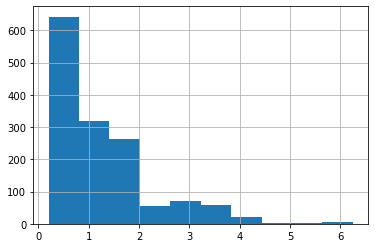

In [47]:
final_meter.groupby('time').global_active_power.mean().hist()

In [48]:
def uniform_noise(day_data, perc_change=2):
#     perc_change = 10
    max_change = day_data.sum()/100*perc_change
    total_size = day_data.shape[0]
    cdf_val = norm.ppf(0.98)
    std = max_change/cdf_val
    uniform_limit = np.sqrt(3*std**2/total_size)
    noise = np.random.uniform(-uniform_limit, uniform_limit, total_size)
    perturbed_data = day_data + noise
    return perturbed_data

def mapd(true_data, pert_data):
    return np.mean(np.abs((true_data - pert_data) / true_data))

def evaluate(true_data, pert_data):
    mse = mean_squared_error(true_data, pert_data)
    corr = np.corrcoef(true_data, pert_data)[0,1]
    print("MSE: ",mse)
    print("Correlation coefficient: ", corr)
    print("Mutual information: ",mutual_information_2d(true_data, pert_data))

In [49]:
period_grouped = final_meter.groupby('date')
perturbed_data = period_grouped['global_active_power'].apply(uniform_noise, (5))
final_meter['uniform_day_active'] = perturbed_data

for period_name, period_data in period_grouped:
    print(period_name)
    evaluate(period_data['global_active_power'],period_data['uniform_day_active'])
# final_meter.groupby('period')['global_active_power','uniform_day_active'].apply(mean_squared_error)
# evaluate(final_meter['global_active_power'],final_meter['uniform_day_active'])

# fig, ax = plt.subplots(2,figsize=(16,4))
# plt.figure(figsize=(16,4))
# final_meter.groupby('time').uniform_day_active.mean().plot()
# final_meter.groupby('time').global_active_power.mean().plot()

2007-06-10 00:00:00
MSE:  1.251054600742946
Correlation coefficient:  0.6938702429881702
Mutual information:  0.7756618139312685


MSE:  1.2181916577184007
Correlation coefficient:  0.6854341111595286
Mutual information:  0.7657497729823488


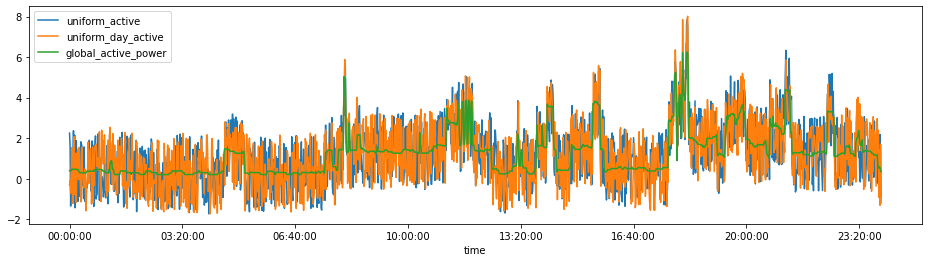

In [50]:
final_meter['uniform_active'] = uniform_noise(final_meter.global_active_power,5)
evaluate(final_meter['global_active_power'],final_meter['uniform_active'])

plt.figure(figsize=(16,4))

final_meter.groupby('time').uniform_active.mean().plot()
final_meter.groupby('time').uniform_day_active.mean().plot()
final_meter.groupby('time').global_active_power.mean().plot()

plt.legend()

In [51]:
final_meter[['global_active_power','uniform_day_active','uniform_active']].agg(['mean','sum'])

,global_active_power,uniform_day_active,uniform_active
mean,1.219611,1.196130,1.235422
sum,1756.240000,1722.427072,1779.007757


In [133]:
scaler1 = MinMaxScaler()
# scaler1 = StandardScaler()
np_power_data = scaler1.fit_transform(final_meter[['global_active_power','time_step']])
np_power_data.max(axis=0)

array([1., 1.])

In [134]:
np_power_data.min(axis=0)

array([0., 0.])

In [210]:
scaler2 = MinMaxScaler((-1,1))
# scaler2 = StandardScaler()
np_perturb_data = scaler2.fit_transform(final_meter['uniform_active'].to_numpy().reshape(-1,1))

In [211]:
np_perturb_data.shape

(1440, 1)

In [212]:
np_power_data[:,0].shape

(1440,)

In [213]:
evaluate(np_power_data[:,0],np_perturb_data.reshape(-1,))

MSE:  0.3552783734946659
Correlation coefficient:  0.685434111159529
Mutual information:  0.7657497729823488


In [214]:
# plt.figure(figsize=(16,8))
# i=0
# for date, power in period_grouped:
# #     print(power.shape)
#     plt.plot(range(power.shape[0]),power)
#     if i>2 : break
#     i += 1
# plt.legend(unq_dates)
# plt.show()

In [215]:
# plt.figure(figsize=(18,8))
# final_meter.groupby('time').global_active_power.mean().plot()

# Neural Networks

In [216]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow import keras
import tensorflow as tf

In [217]:
# print("Setting up model-specific variables...")
# K.clear_session()
# maxlen = 1440
# batch_size = 64
# embedding_size = 128
# lstm_size = 1440
# val_split = 0.2
# epochs = 12
# num_classes = 2

# seq_encode = Input(shape=(maxlen,))
# embeddings = Embedding(max_features, embedding_size)(seq_encode)
# lstm_out = LSTM(lstm_size, dropout=0.2, recurrent_dropout=0.2)(embeddings)
# dense_out = Dense(num_classes)(lstm_out)
# out = Activation('softmax')(dense_out)

In [294]:
# K.clear_session()
# activation = 'relu'
input_layer = Input(shape=(2,))
dense = Dense(1000, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1),
               activation='selu')(input_layer)
dense = Dense(1000, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1),
              activation='selu')(dense)
# dense = Dense(1000, activation='tanh')(dense)
# dense = Dense(1000, activation='tanh')(dense)
# dense = Dense(100)(dense)
# dense = Dense(100)(dense)
# dense = Dense(100, activation='relu')(dense)
out = Dense(1, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1),
            activation='tanh')(dense)

regr = Model(input_layer, out)
# regr.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.MeanSquaredError()])
regr.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.01))
# regr.summary()

In [295]:
train_history = regr.fit(np_power_data, np_perturb_data,
#                              validation_data=(x_test, y_test_oe),
#                              validation_split=0.2,
                             batch_size=8,
                             epochs=50
                             )

Epoch 1/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2336
Epoch 2/50
180/180 [==============================] - 0s 3ms/step - loss: 0.2096
Epoch 3/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2046
Epoch 4/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2008
Epoch 5/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1997
Epoch 6/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2009
Epoch 7/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1998
Epoch 8/50
180/180 [==============================] - 0s 3ms/step - loss: 0.1998
Epoch 9/50
180/180 [==============================] - 0s 3ms/step - loss: 0.1995
Epoch 10/50
180/180 [==============================] - 0s 3ms/step - loss: 0.2001
Epoch 11/50
180/180 [==============================] - 0s 3ms/step - loss: 0.2001
Epoch 12/50
180/180 [==============================] - 0s 3ms/step - loss: 0.1993
Epoch 13/50
180/180 [====

In [287]:
final_meter['uniform_active']

422316    2.249855
422317    1.627807
422318   -1.350723
422319    0.206498
422320   -0.085776
            ...   
423751    0.961959
423752    0.525048
423753    2.185661
423754    0.790155
423755   -0.870556
Name: uniform_active, Length: 1440, dtype: float64

In [288]:
res = regr.predict(np_power_data)
res2 = scaler2.inverse_transform(res)
res2[res2>0].shape

(1440,)

In [289]:
res2

array([[0.20250879],
       [0.20073648],
       [0.19899845],
       ...,
       [0.64301807],
       [0.54471   ],
       [0.5066352 ]], dtype=float32)

In [290]:
final_meter['neural_active'] = res2

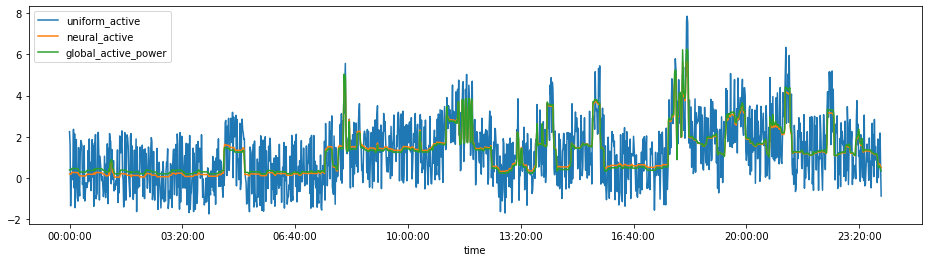

In [291]:

plt.figure(figsize=(16,4))

final_meter.groupby('time').uniform_active.mean().plot()
final_meter.groupby('time').neural_active.mean().plot()
final_meter.groupby('time').global_active_power.mean().plot()

plt.legend()

In [245]:
print("Setting up model-specific variables...")
K.clear_session()
batch_size = 64
embedding_size = 128
lstm_size = 128
val_split = 0.2
epochs = 12
num_classes = 2

Setting up model-specific variables...


In [157]:
seq_encode = Input(shape=(maxlen,))
embeddings = Embedding(max_features, embedding_size)(seq_encode)
lstm_out = LSTM(lstm_size, dropout=0.2, recurrent_dropout=0.2)(embeddings)
dense_out = Dense(num_classes)(lstm_out)
out = Activation('softmax')(dense_out)

NameError: name 'maxlen' is not defined

In [158]:
regr = Model(input_layer, out)
# regr.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.MeanSquaredError()])
regr.compile(loss='mse', optimizer='sgd')
regr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_80 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_81 (Dense)             (None, 500)               50500     
_________________________________________________________________
dense_82 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 11        
Total params: 55,721
Trainable params: 55,721
Non-trainable params: 0
_________________________________________________________________
